# Matt Sloane / ms9548

## Homework 10 Notebook
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
# Note - Various modules imported throughout example code have all been consolidated here
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
%matplotlib inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
# Altered for PUI Data Class Format 

def get_data():
    '''
    This function downloads the Homework 10 datasets as provided and moves them to the PUI Data directory)
    '''
    
    # Make new directory within PUI Data folder for assignment specific data
    os.system("mkdir " + os.getenv("PUIDATA") + "/HW10_Data")
    
    # Download Data from Github
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/ACS_CT2010.csv")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CitiBike_monthly_byStation.csv")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/Station_id.csv")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/R10_BoroCT2010.csv")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.cpg")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.dbf")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.prj")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shp")
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shx")
                    
    #Move Data to PUI Data folder    
    os.system("mv " + "ACS_CT2010.csv " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "CitiBike_monthly_byStation.csv " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "Station_id.csv " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "R10_BoroCT2010.csv " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "ct_shape.cpg " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "ct_shape.dbf " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "ct_shape.prj " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "ct_shape.shp " + os.getenv("PUIDATA")+"/HW10_Data")
    os.system("mv " + "ct_shape.shx " + os.getenv("PUIDATA")+"/HW10_Data")

        
get_data()    

In [4]:
shape_path = os.getenv("PUIDATA") + "/HW10_Data/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [5]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

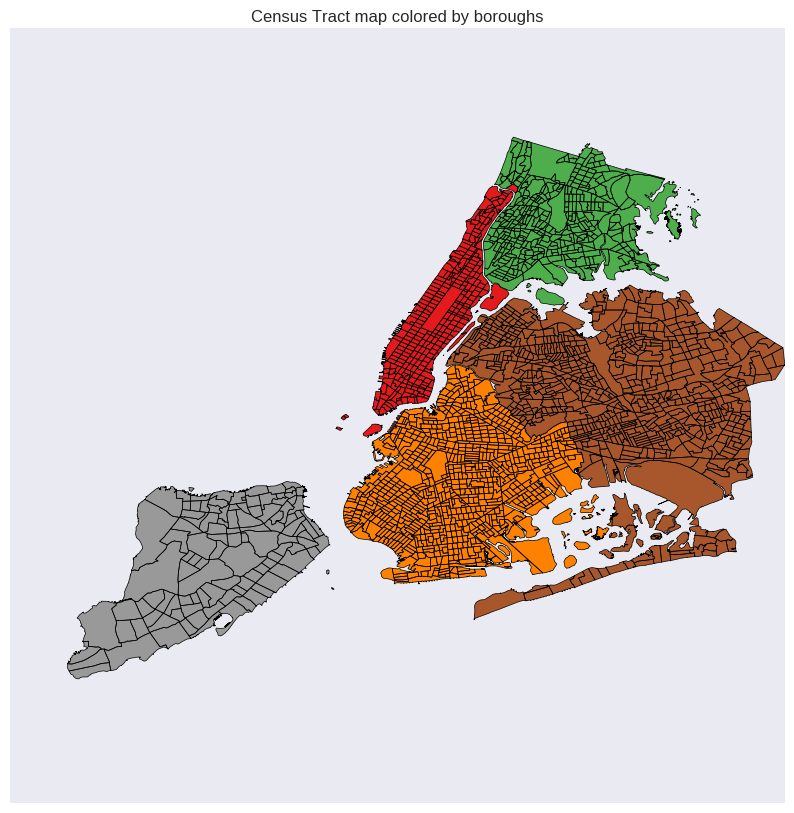

In [6]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density
#### Load Census Data for 2010

In [7]:
ct_data=DataFrame.from_csv(os.getenv("PUIDATA") + "/HW10_Data/ACS_CT2010.csv")
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [8]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


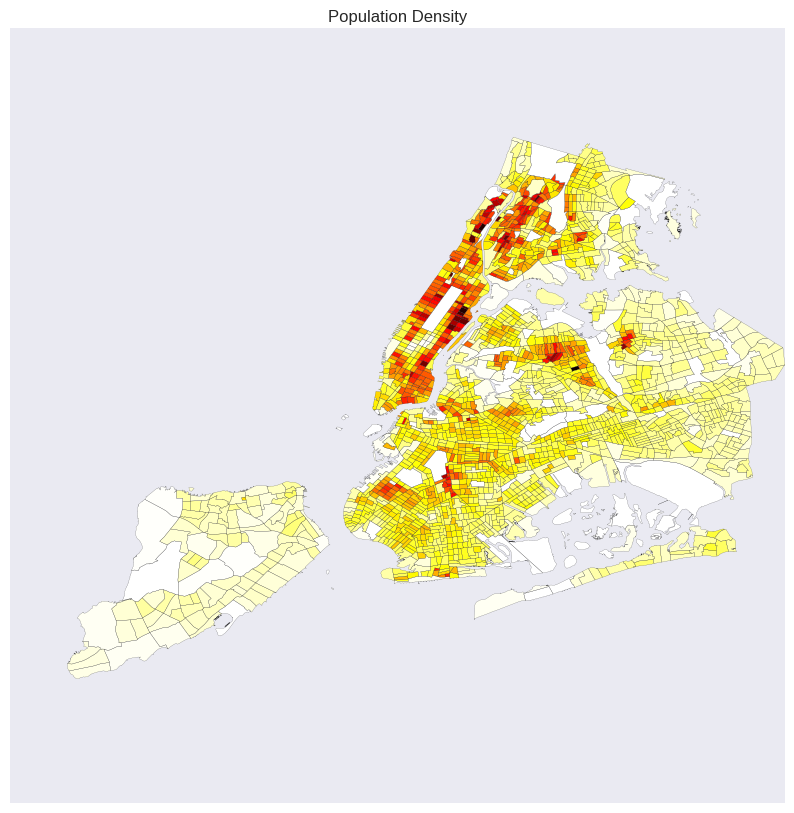

In [9]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data
### Load CitiBike data

In [10]:
df_bike_monthly=DataFrame.from_csv(os.getenv("PUIDATA") + '/HW10_Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Create Data Frames seaparating stats for Summer and Winter Months - code / direction provided by
# Kelsey Reid / kdr276

# Summer Months DataFrame (April - September)
df_bike_summer = df_bike_monthly.iloc[[0,1,2,9,10,11,12,13,14,21,22,23,24,25,26,33,34,35], :]

# Winter Months DataFrame (October - March)
df_bike_winter = df_bike_monthly.iloc[[3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32], :]

### Time Series Analysis
#### Summer Months

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

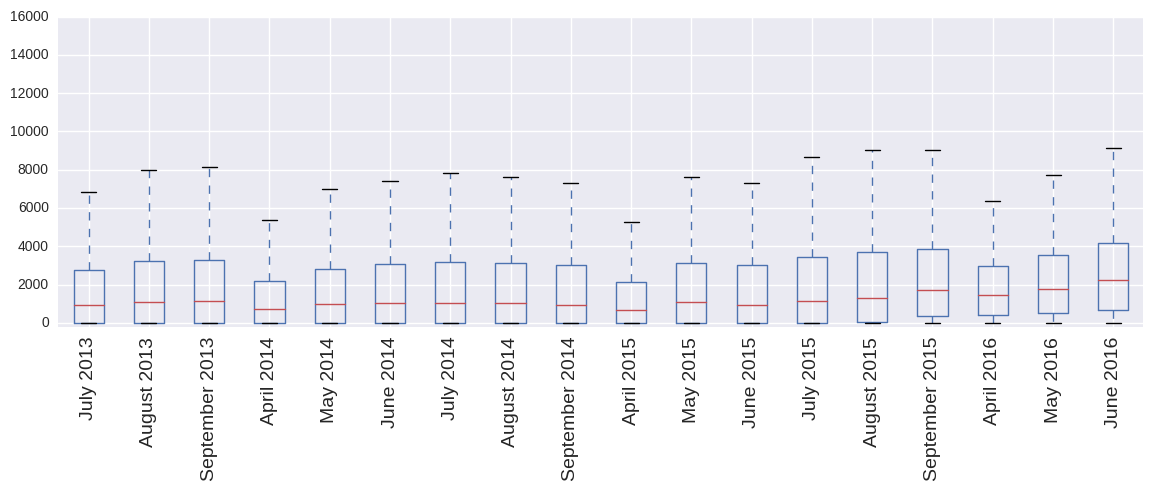

In [12]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_summer_=df_bike_summer.copy()
df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

### Time Series Analysis
#### Winter Months

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

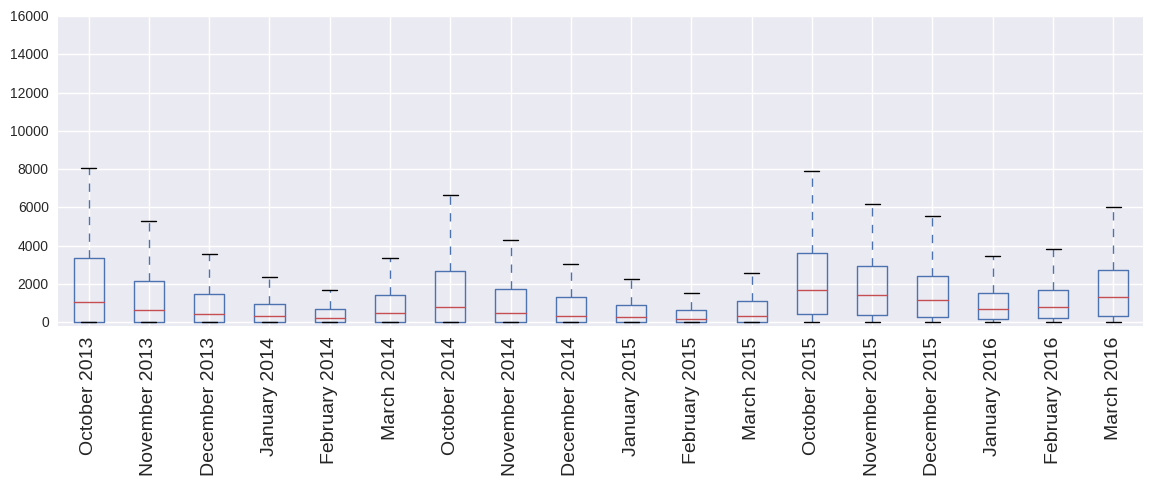

In [13]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


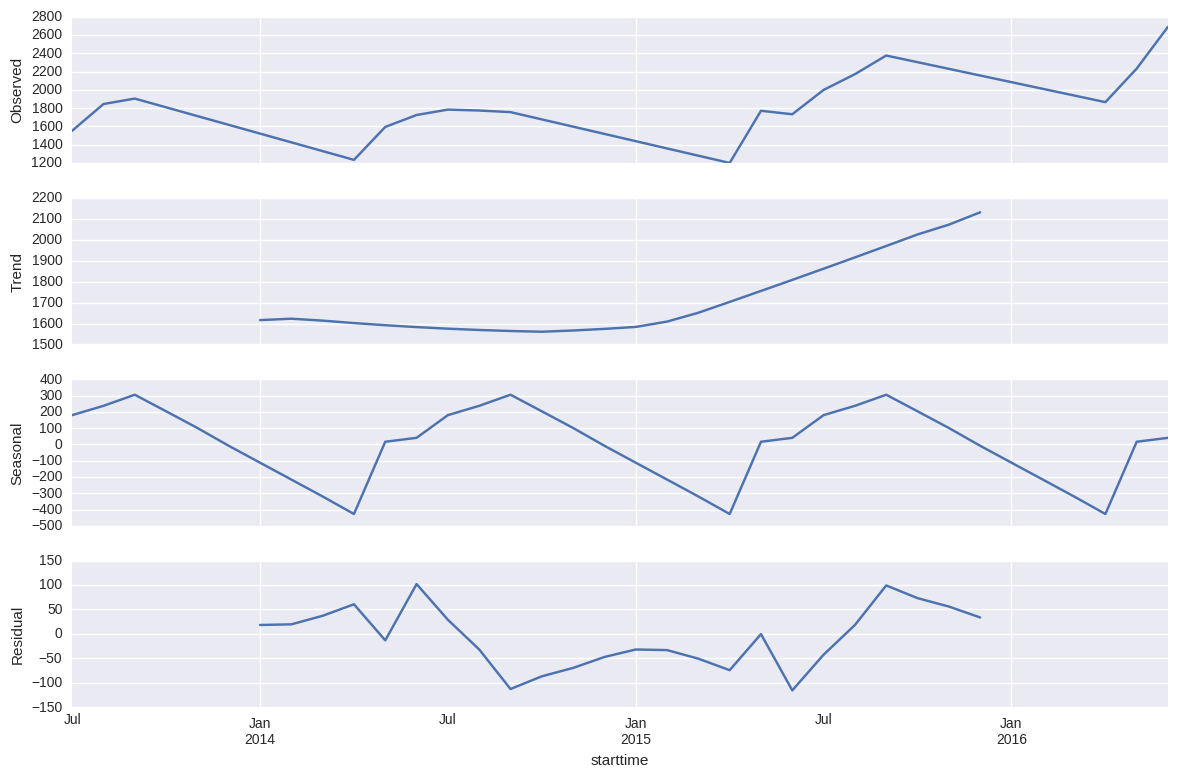

In [14]:
#Create a monthly time series of bike ride (Average of all citibike stations) - SUMMER MONTHS
df_new_S=df_bike_summer.mean(1).resample('M').mean()
df_new_S.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new_S.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

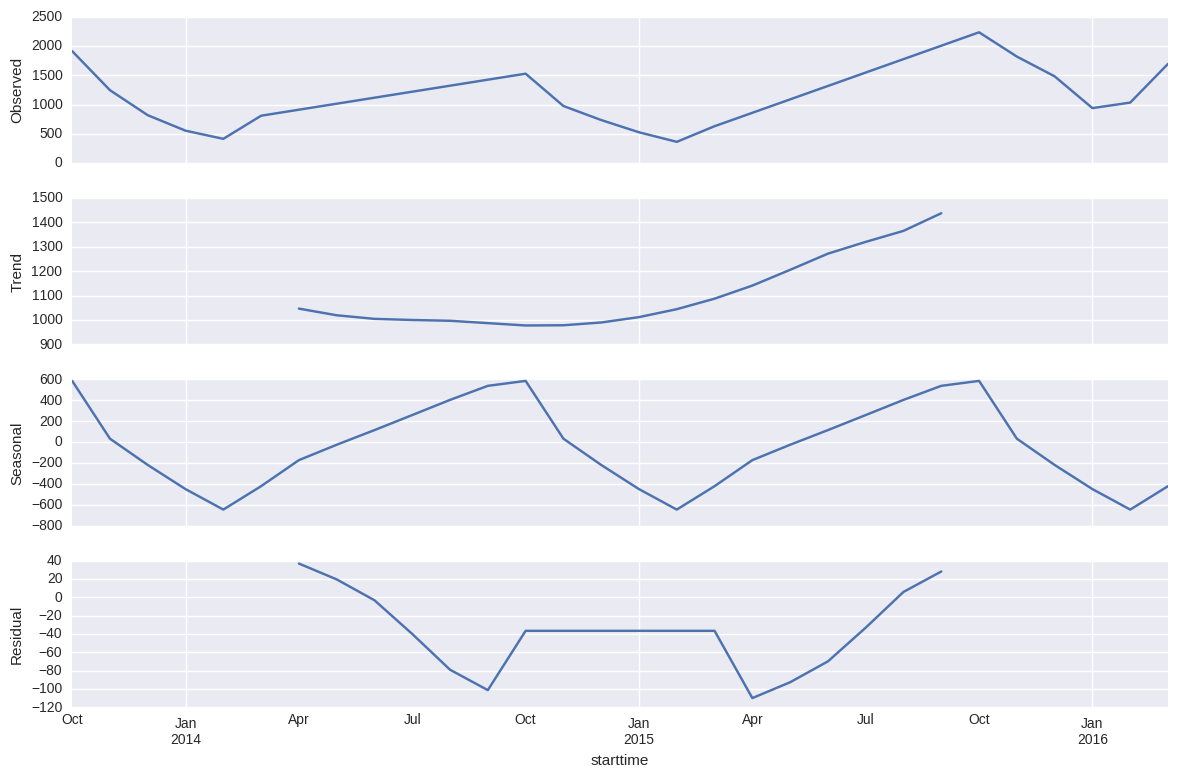

In [15]:
#Create a monthly time series of bike ride (Average of all citibike stations) - WINTER MONTHS
df_new_W=df_bike_winter.mean(1).resample('M').mean()
df_new_W.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new_W.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [16]:
station_id=DataFrame.from_csv(os.getenv("PUIDATA") + "/HW10_Data/Station_id.csv")
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [17]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [18]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [19]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [20]:
### Create average monthly rides columns for summer and winter averages
station_id['Summer_Avg']=df_bike_summer.sum()
station_id['Winter_Avg']=df_bike_winter.sum()

In [21]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,Summer_Avg,Winter_Avg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,42378,26930
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,67646,35178
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,169085,104440
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,64084,37865
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,116324,67720


### Add the summer and winter average rides to the CT shapefile 

In [22]:
temp=station_id[['Summer_Avg', 'Winter_Avg']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


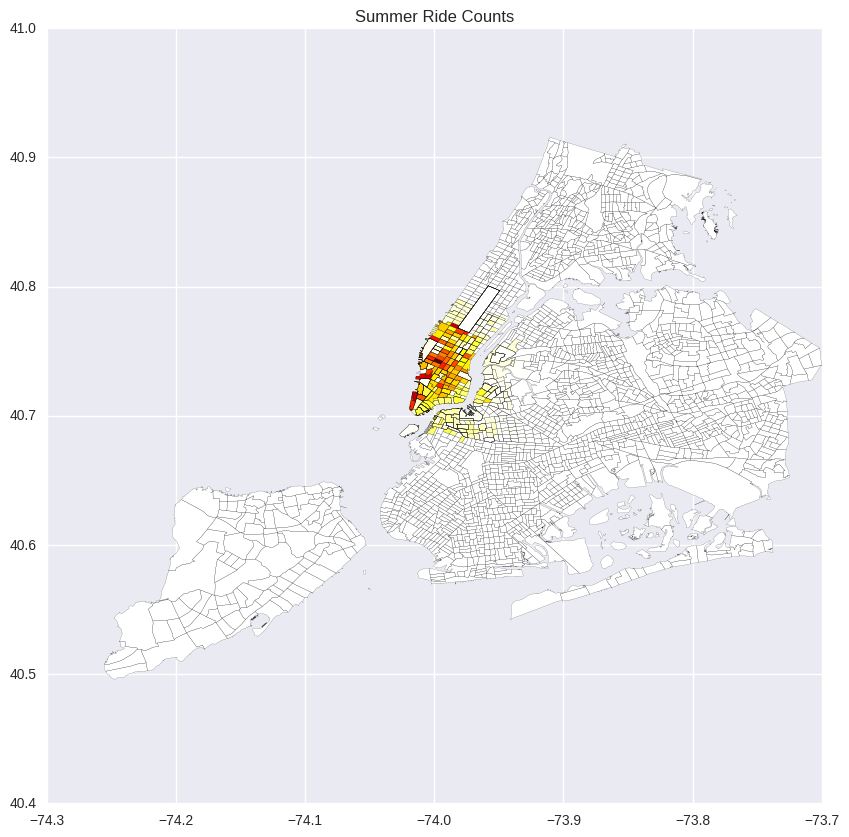

In [23]:
# Summer Ride Counts Map
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='Summer_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

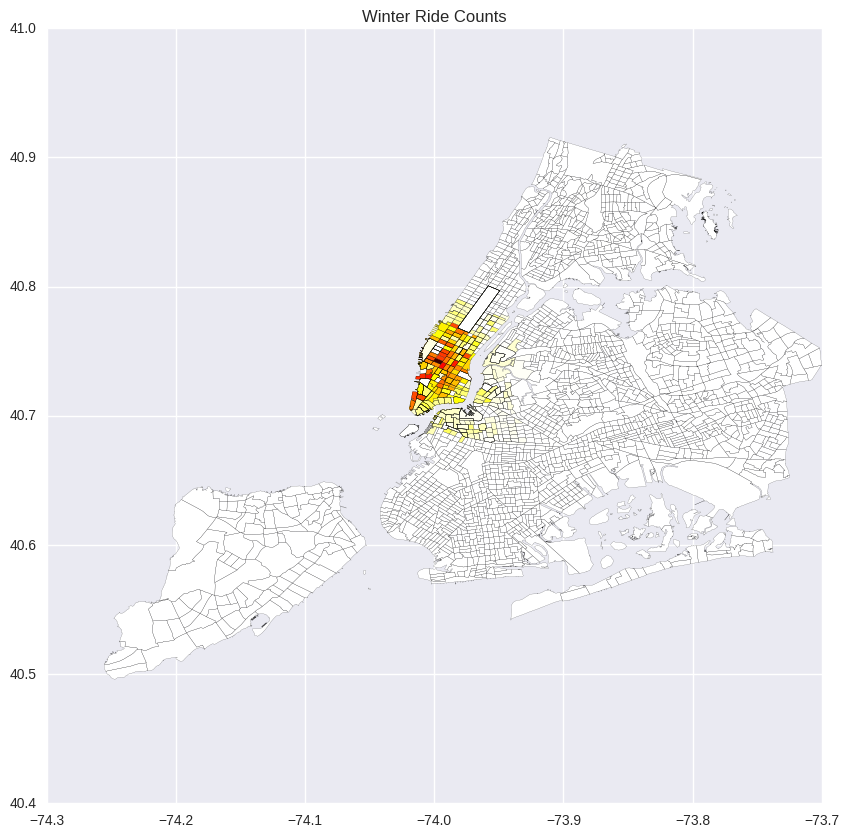

In [24]:
# Winter Ride Counts Map
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='Winter_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

### Removing the CTs that are out of zoom boundries

In [25]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [26]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.Summer_Avg)  # Note: Length of Summer CTs == Length of Winter CTs

Total number of CTs: 2166
Number of zoomed CTs: 543


### Zoom Map the monthly rides - Summer

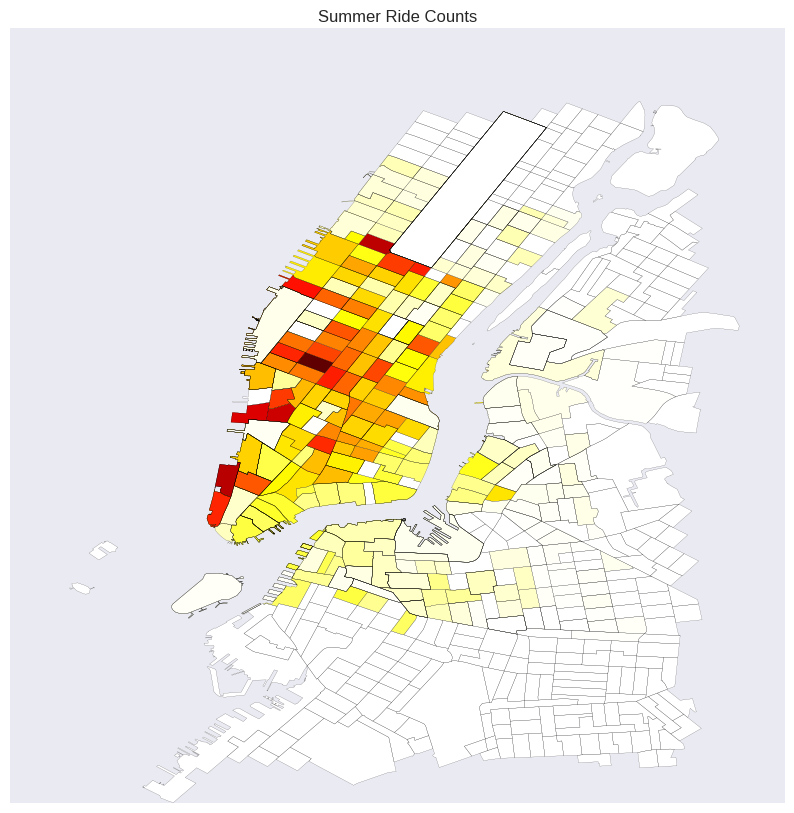

In [27]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='Summer_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

### Zoom Map the monthly rides - Winter

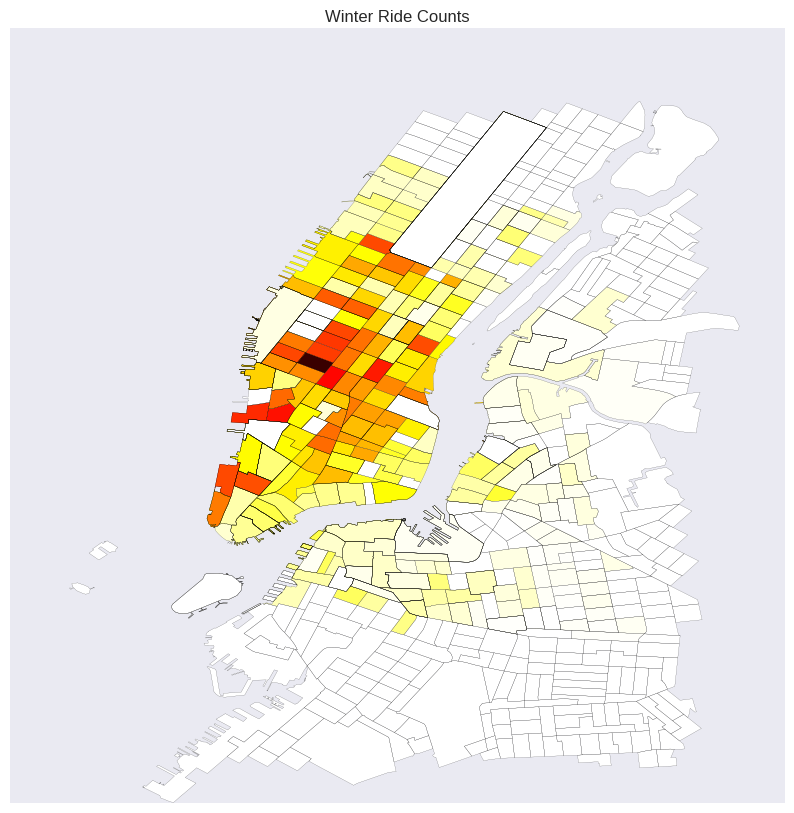

In [28]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='Winter_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [29]:
path = os.getenv("PUIDATA") + "/HW10_Data/ct_shape_MonthlyAve_Zoom.shp"
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis
### Spatial Weights
Contiguity: Queen Weights

In [30]:
qW_CT=ps.queen_from_shapefile(path)

Island id:  [0]


#### Neighbors of index 10

In [31]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [32]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [33]:
Wmatrix, ids = qW_CT.full()

In [34]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [35]:
qW_CT.transform = 'r'

### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [36]:
# Lags for Summer and Winter Rides:

# SUMMER:

summer_Ride = ct_shape_MonthlyAve_Zoom.Summer_Avg
summer_Ride_Lag = ps.lag_spatial(qW_CT, summer_Ride)

# WINTER:

winter_Ride = ct_shape_MonthlyAve_Zoom.Winter_Avg
winter_Ride_Lag = ps.lag_spatial(qW_CT, winter_Ride)

#### Create Quantiles for mapping - Winter and Summer

In [37]:
summerRideLagQ10 = ps.Quantiles(summer_Ride_Lag, k = 10)
winterRideLagQ10 = ps.Quantiles(winter_Ride_Lag, k = 10)

print (summerRideLagQ10)
print (winterRideLagQ10)

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   137.571                21
  137.571 < x[i] <=  2404.850                78
 2404.850 < x[i] <=  5510.364                80
 5510.364 < x[i] <= 11145.782                79
11145.782 < x[i] <= 16953.467                80
16953.467 < x[i] <= 36421.278                79
36421.278 < x[i] <= 52710.200                80
52710.200 < x[i] <= 61019.750                79
61019.750 < x[i] <= 94018.643                80
                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=   100.000                 2
  100.000 < x[i] <=  1652.442                78
 1652.442 < x[i] <=  4131.471                80
 4131.471 < x[i] <=  6582.023                79
 6582.023 < x[i] <=  9880.056                80
 9880.056 < x[i] <= 21830.992       

#### Map the Summer and Winter Lags

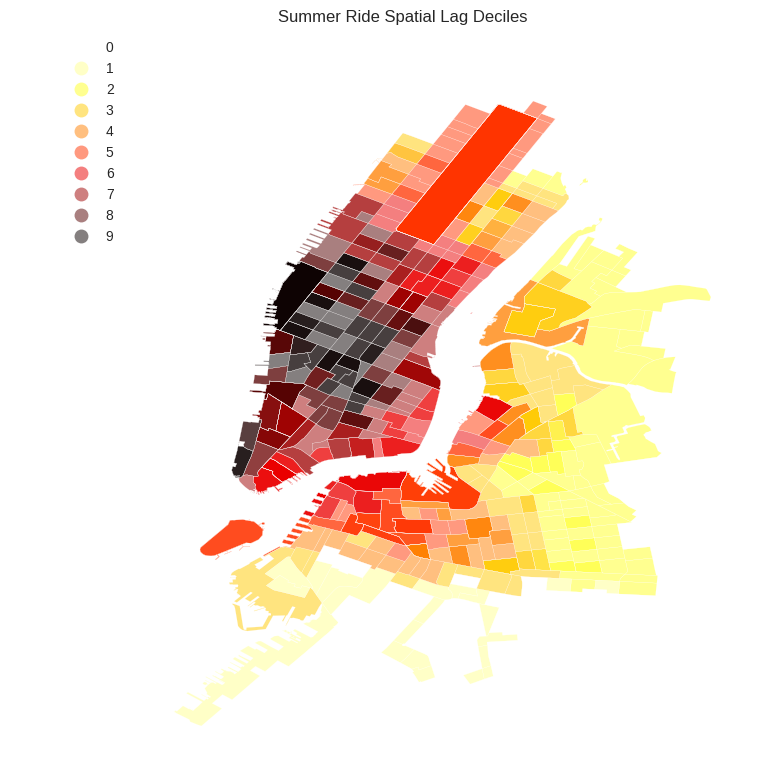

In [38]:
# SUMMER
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=summerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

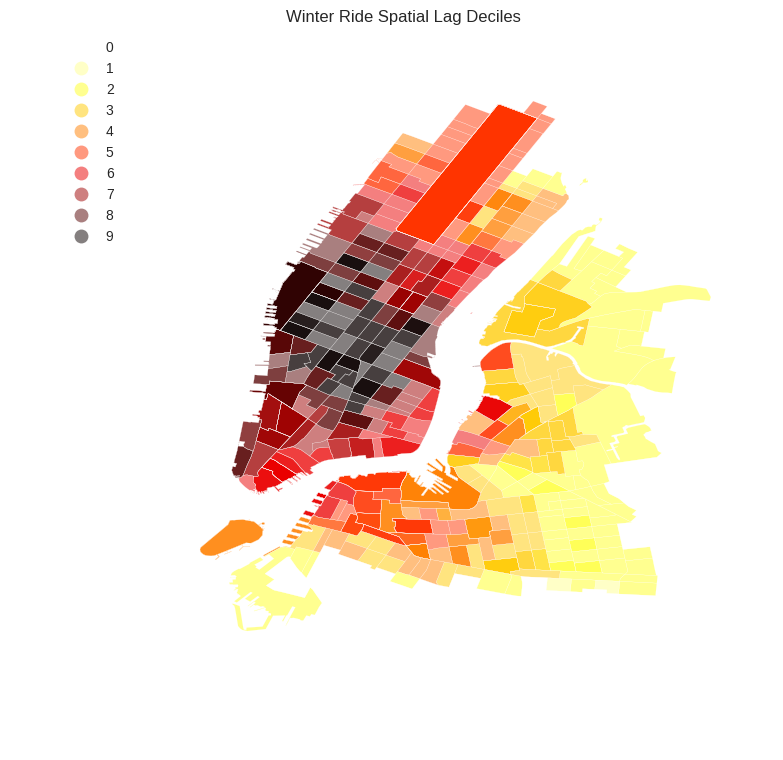

In [39]:
# WINTER
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=winterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [40]:
b1,a1 = np.polyfit(summer_Ride, summer_Ride_Lag, 1)  # summer
b2,a2 = np.polyfit(winter_Ride, winter_Ride_Lag, 1)

print (b1,a1) 
print (b2,a2) 

(0.64466687635049424, 8128.844260081486)
(0.65962241090192864, 4623.7815625116482)


### Moran Scatterplot - Summer

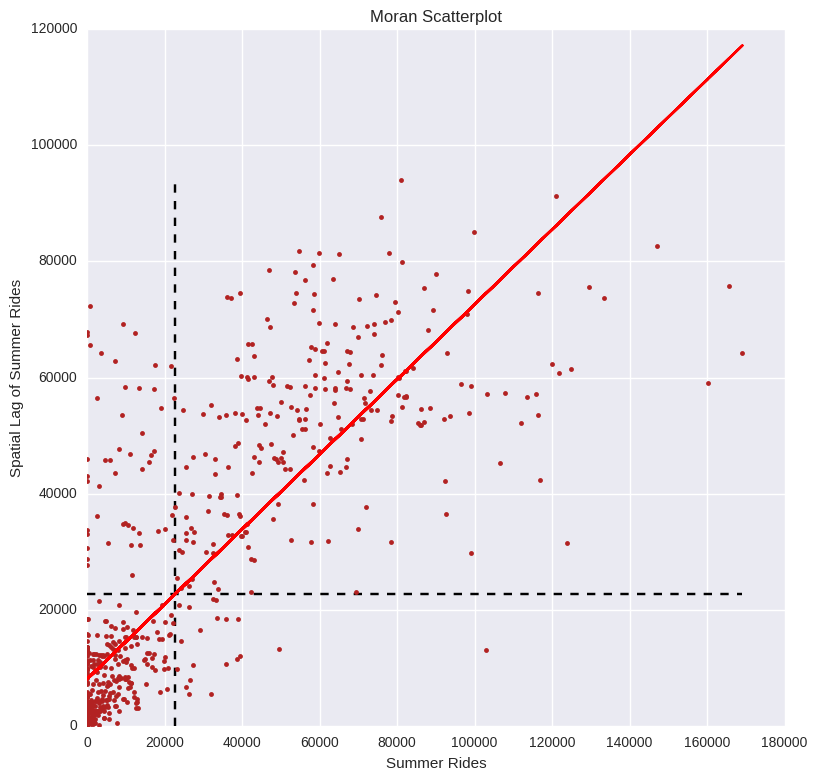

In [41]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(summer_Ride, summer_Ride_Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(summer_Ride.mean(), summer_Ride_Lag.min(), summer_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(summer_Ride_Lag.mean(), summer_Ride.min(), summer_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(summer_Ride, a1 + b1*summer_Ride, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

### Moran Scatterplot - Winter

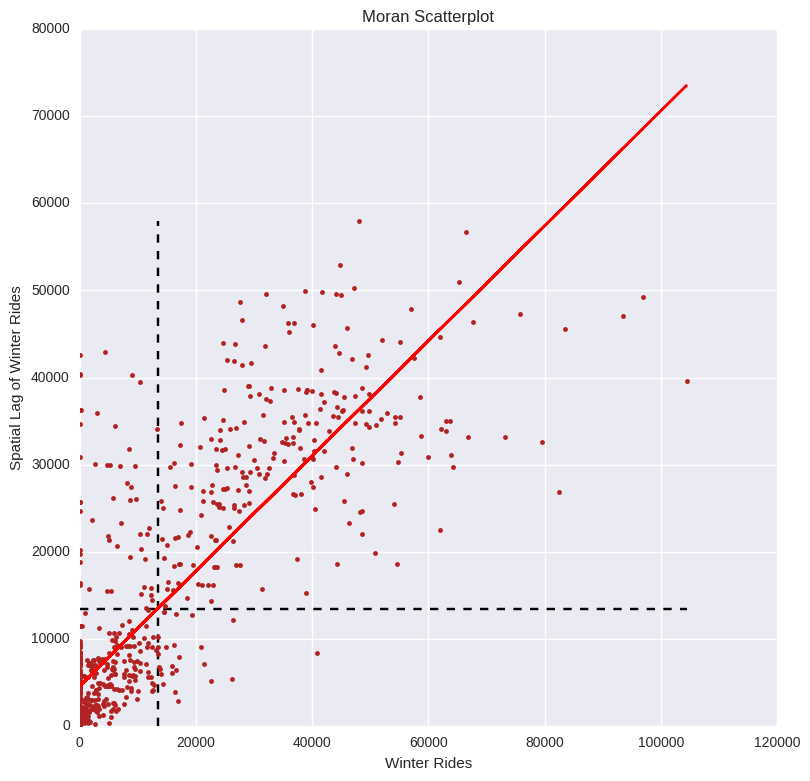

In [42]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(winter_Ride, winter_Ride_Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(winter_Ride.mean(), winter_Ride_Lag.min(), winter_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winter_Ride_Lag.mean(), winter_Ride.min(), winter_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winter_Ride, a2 + b2*winter_Ride, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

### Moran's I

In [43]:
summer_I = ps.Moran(summer_Ride, qW_CT)   # Summer
winter_I = ps.Moran(winter_Ride, qW_CT)   # Winter

In [44]:
print(summer_I.I, summer_I.p_sim) # Summer
print(winter_I.I, winter_I.p_sim) # Winter

(0.64482518848460035, 0.001)
(0.65977718610668423, 0.001)


In [45]:
print (summer_I.sim[0:10])  # Summer
print (winter_I.sim[0:10])  # Winter

[-0.01415951 -0.01550455  0.01387562  0.00793262 -0.00520393 -0.01245827
 -0.02192126 -0.01371111  0.00739919  0.00640357]
[-0.00666057 -0.01077391  0.01486234 -0.00569054 -0.00267511 -0.00930048
  0.01331225 -0.00194586  0.0010368  -0.00672364]


### KDEplot of all of the simulated points - Summer and Winter
the vertical line shows the observed value

In [46]:
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

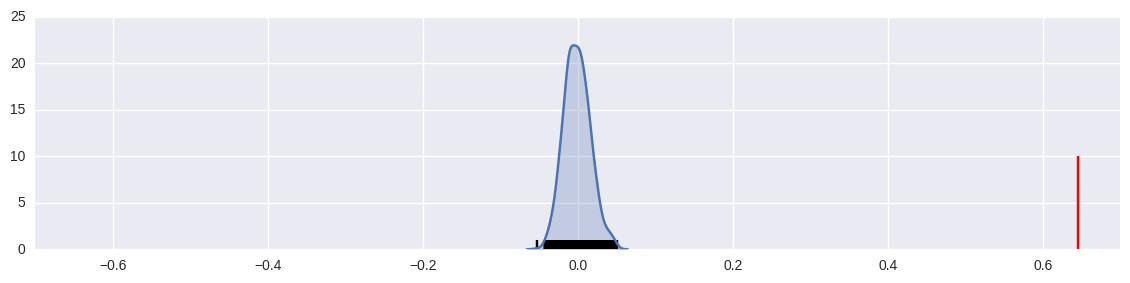

In [47]:
# KDE plots - Summer
sns.kdeplot(summer_I.sim, shade=True)
plt.vlines(summer_I.sim, 0, 1)
plt.vlines(summer_I.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

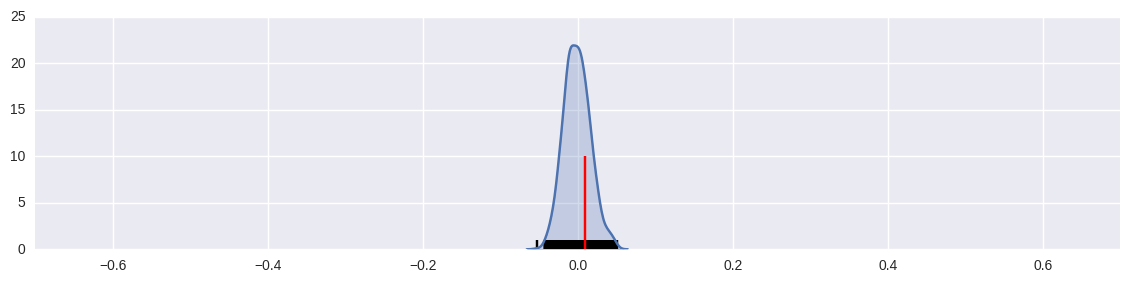

In [48]:
sns.kdeplot(summer_I.sim, shade=True)
plt.vlines(summer_I.sim, 0, 1)
plt.vlines(summer_I.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

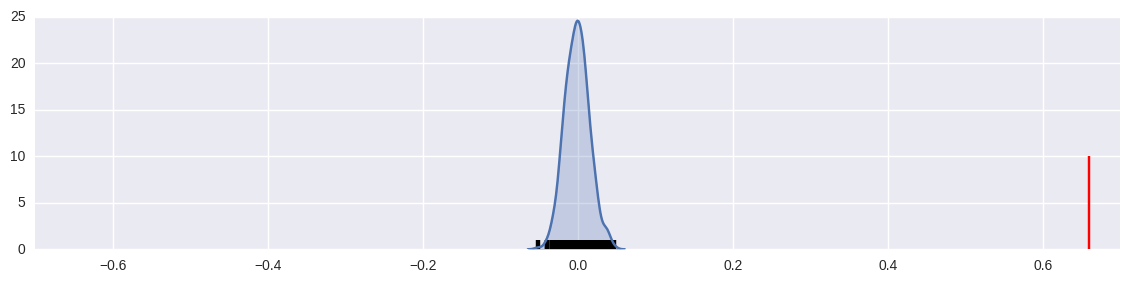

In [49]:
# KDE plots - Winter
sns.kdeplot(winter_I.sim, shade=True)
plt.vlines(winter_I.sim, 0, 1)
plt.vlines(winter_I.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

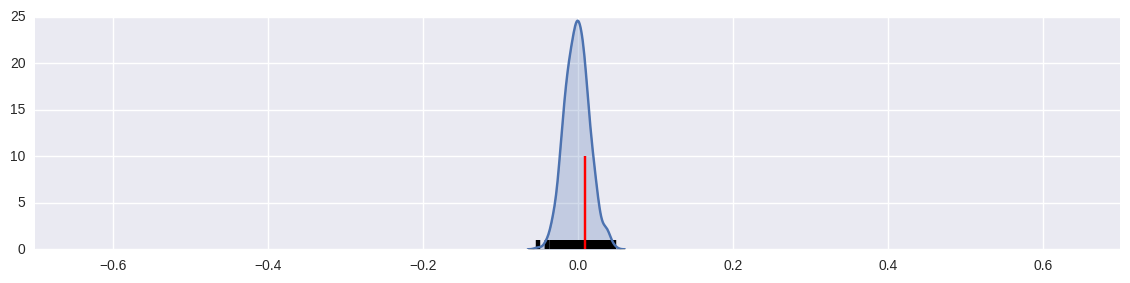

In [50]:
sns.kdeplot(winter_I.sim, shade=True)
plt.vlines(winter_I.sim, 0, 1)
plt.vlines(winter_I.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [51]:
LMo_SummerRide = ps.Moran_Local(summer_Ride, qW_CT, permutations=999) # Summer
#LMo_WinterRide = ps.Moran_Local(winter_Ride, qW_CT, permutations=999) # Winter

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


ValueError: Lengths must match to compare

In [ ]:
summer_Ride

{137: 0.14285714285714285,
 701: 0.14285714285714285,
 702: 0.14285714285714285,
 703: 0.14285714285714285,
 704: 0.14285714285714285,
 708: 0.14285714285714285,
 709: 0.14285714285714285}